In [1]:
%load_ext autoreload
%autoreload 2

In [1659]:
%run imports.py

In [243]:
def get_mrs_fitness(x, mrs, optim_fn, n_samples=None):
    for _ in range(x.ndim):
        mrs = mrs[..., None]
    shape = list(x.shape)
    if n_samples is not None:
        shape = [n_samples] + shape
        mrs = mrs[..., None]
    xmut = x+torch.randn(shape).to(x)*mrs
    fit_diff = optim_fn(xmut) - optim_fn(x)
    return x, xmut, fit_diff

def get_optimal_mr_extreme(x, mrs, optim_fn, n_samples=None):
    x, xmut, fit_diff = get_mrs_fitness(x, mrs, optim_fn, n_samples)
    return mrs[fit_diff.min(dim=-1).values.argmin(dim=0)]

def get_optimal_mr_look_ahead(x, mrs, optim_fn, n_gen=10, n_samples=1):
    if x.ndim==2:
        x = x[None]
    f = []
    for xi in x:
        for mr in mrs:
            for i in range(n_samples):
                pops, fits = optim.run_evolution_base(xi, optim_fn, n_gen, mr=mr)
                f.append(fits.min())
    f = torch.stack(f).reshape(len(x), len(mrs), n_samples)
    return mrs[f.mean(dim=-1).argmin(dim=-1)]

In [349]:
def run_evolution_look_ahead(pop, optim_fn, n_gen, look_ahead, mrs=None, tqdm=None):
    if mrs is None:
        mrs = torch.logspace(-3, 3, 15)
    
    data = []
    loop = range(n_gen)
    if tqdm is not None:
        loop = tqdm(loop)
    for gen_idx in loop:
        mr = get_optimal_mr_look_ahead(pop, mrs, ackley, n_gen=look_ahead)
        pops, fits = optim.run_evolution_base(pop, ackley, 2, mr=mr)
        pop = pops[-1]
        fit = fits[-1]
        data.append((pop, fit, mr))
        
    pops = torch.stack([i[0] for i in data])
    fits = torch.stack([i[1] for i in data])
    mutpops = torch.stack([i[2] for i in data])
    return pops, fits, mutpops


100%|██████████| 20/20 [00:00<00:00, 1163.69it/s]


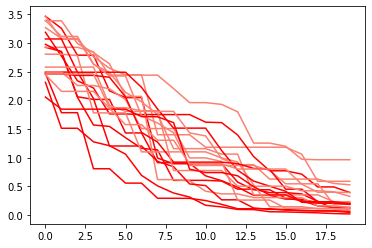

In [350]:
n_gen = 20
f = []
for i in range(10):
    pop = torch.randn(51, 5)
    pops, fits, mutpops = run_evolution_look_ahead(pop, ackley, n_gen, 5, tqdm=tqdm)
    f.append(fits)
    plt.plot(fits.min(dim=-1).values, c='r')
    pops, fits, mutpops, mr_fits = optim.run_evolution_mutpops_full(pop, ackley, n_gen, tqdm=tqdm)
    f.append(fits)
    plt.plot(fits.min(dim=-1).values, c='salmon')

In [351]:
f = torch.stack(f).reshape(10, 2, 20, 51)

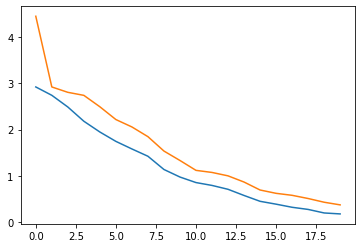

In [352]:
plt.plot(f.mean(dim=0)[0].min(dim=-1).values)
plt.plot(f.mean(dim=0)[1].min(dim=-1).values)

In [179]:
pop = torch.randn(51, 3)
pops, fits = optim.run_evolution_base(pop, ackley, 40, mr=1e-2)

In [180]:
pops.shape, fits.shape

(torch.Size([40, 51, 3]), torch.Size([40, 51]))

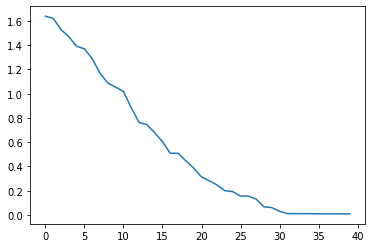

In [181]:
plt.plot(fits.min(dim=-1).values);

100%|██████████| 40/40 [00:03<00:00, 12.91it/s]


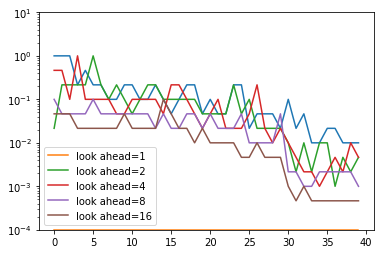

In [183]:
mrs = torch.logspace(-4, 1, 16)
mr = get_optimal_mr_extreme(pops, mrs, ackley)
plt.plot(mr)
for look_ahead in [1, 2, 4, 8, 16]:
    mr = get_optimal_mr_look_ahead(pops, mrs, ackley, n_gen=look_ahead)
    plt.plot(mr, label=f'look ahead={look_ahead}')
plt.yscale('log')
plt.ylim(mrs.min(), mrs.max())
plt.legend()

100%|██████████| 10/10 [00:23<00:00,  2.30s/it]


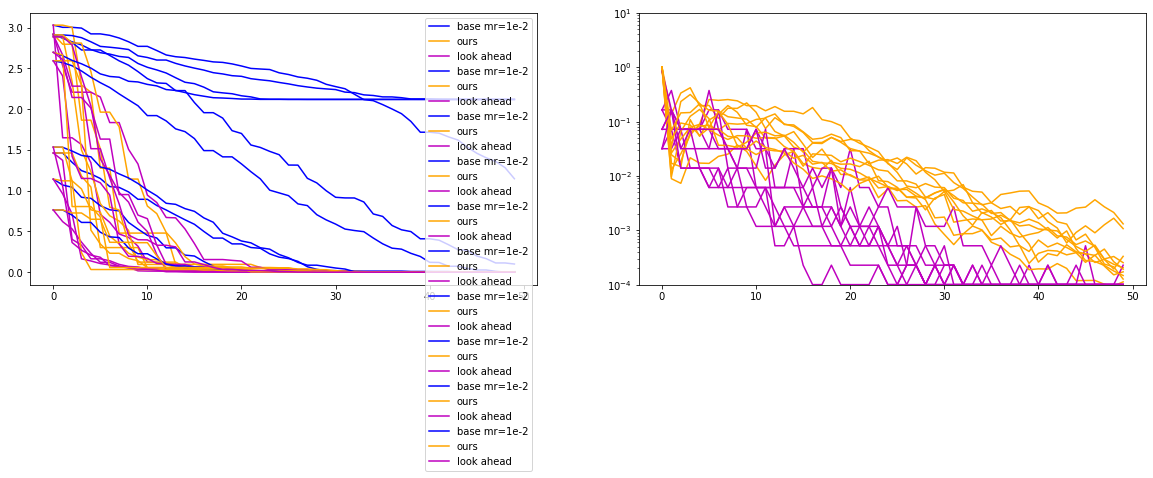

In [288]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
for i in tqdm(range(10)):
    pop = torch.randn(31, 3)
    pops, fits = optim.run_evolution_base(pop, ackley, 50, mr=1e-2)
    axs[0].plot(fits.min(dim=-1).values, c='b', label='base mr=1e-2')
    pops, fits, mr_pop, _ = optim.run_evolution_mutpops_full(pop, ackley, 50, mr=None)
    axs[0].plot(fits.min(dim=-1).values, c='orange', label='ours')
    p = pop
    f = []
    ms = []
    for gen_idx in range(50):
        mr = torch.tensor(1e-2)
        mrs = torch.logspace(-4, 1, 15)
        mr = get_optimal_mr_look_ahead(p, mrs, ackley, 10)
        ms.append(mr)
        p, fits = optim.run_evolution_base(p, ackley, 2, mr=mr)
        p = p[-1]
        f.append(fits[0])
    f = torch.stack(f)
    axs[0].plot(f.min(dim=-1).values, c='m', label='look ahead')
    axs[0].legend()
    axs[1].plot(torch.stack(ms), c='m')
    axs[1].plot(mr_pop[:, :, 0].log().mean(dim=-1).exp(), c='orange')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-4, 1e1)
plt.show()

torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])
torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])
torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])
torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])
torch.Size([40, 51, 3]) torch.Size([30, 40, 51, 3]) torch.Size([30, 40, 51])


(0.001, 1000.0)

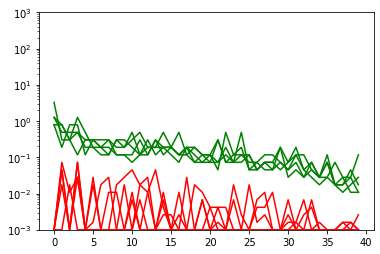

In [132]:
mrs = torch.logspace(-3, 3, 30)
for _ in range(5):
    x, xmut, fit_diff = get_mrs_fitness(pops, mrs, ackley)
    print(x.shape, xmut.shape, fit_diff.shape)
    plt.plot(mrs[fit_diff.min(dim=-1).values.argmin(dim=0)], c='g')
    plt.plot(mrs[fit_diff.mean(dim=-1).argmin(dim=0)], c='r')
plt.yscale('log')
plt.ylim(1e-3, 1e3)

In [129]:
mrs = torch.logspace(-3, 3, 10)
gens = torch.arange(0, len(pops), 2)
ms = []
for x in tqdm(pops[gens]):
    f = get_optimal_mrs(x, mrs, ackley, 10, 1)
    ms.append(mrs[f.mean(dim=-1).argmin()])

100%|██████████| 20/20 [00:00<00:00, 31.50it/s]


(0.001, 1000.0)

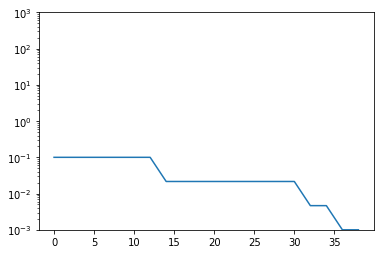

In [130]:
plt.plot(gens, ms)
plt.yscale('log')
plt.ylim(1e-3, 1e3)

<ipython-input-1664-a1372e9a769b>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, z)


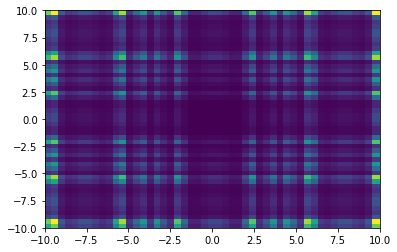

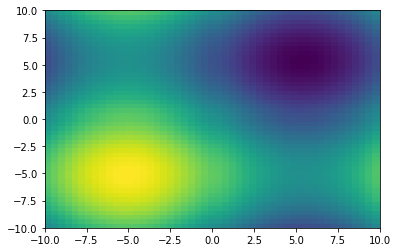

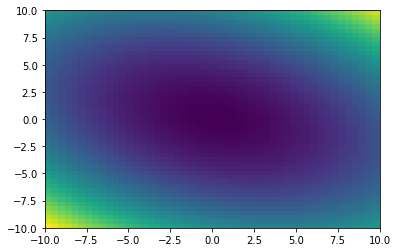

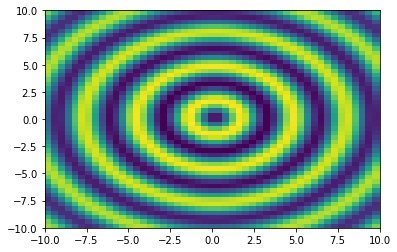

In [1664]:
x = torch.linspace(-10, 10, 50)
y = torch.linspace(-10, 10, 50)
# x = torch.linspace(-500, 500, 1000)
# y = torch.linspace(-500, 500, 1000)
x, y = torch.meshgrid(x, y)

for optim_fn in [xin_she_yang, schwefel, zakharov, schaffer]:
    z = torch.stack([x, y], dim=-1)
    z = optim_fn(z)
    plt.pcolormesh(x, y, z)
    plt.show()
    

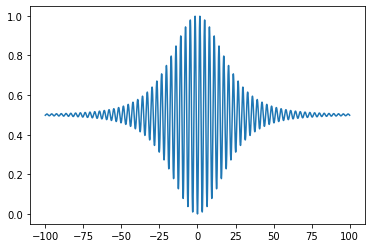

In [1663]:
x = torch.linspace(-100, 100, 10000)
plt.plot(x, schaffer(x[:, None]))

In [1603]:
def calc_npop_idxs(fit, k=.5, k_elite=None):
    k = int(len(fit)*k)
    if k_elite is None:
        k_elite = 1
    else:
        k_elite = int(len(fit)*k_elite)
    idxs_sort = torch.argsort(fit)
    idxs_elite = idxs_sort[:k_elite]
    idxs_rest = idxs_sort[:k]
    n_children = len(fit)-k_elite
    idxs_rest = idxs_rest[np.random.choice(len(idxs_rest), size=(n_children, ), replace=True)]
    idxs_cat = torch.cat([idxs_elite, idxs_rest], dim=-1)
    return idxs_elite, idxs_rest, idxs_cat

def calc_npop_gaussian(pop, mr, 
                       idxs_elite, idxs_rest, idxs_cat=None):
    npop = torch.zeros_like(pop)
    npop[:len(idxs_elite)] = pop[idxs_elite]
    p = pop[idxs_rest]
    eps = torch.randn_like(p)
    npop[len(idxs_elite):] = p+eps*mr
    return npop

def calc_npop_gaussian_mean_std(pop, mr_mean, mr_std, 
                                idxs_elite, idxs_rest, idxs_cat=None):
    npop = torch.zeros_like(pop)
    npop[:len(idxs_elite)] = pop[idxs_elite]
    p = pop[idxs_rest]
    eps = torch.randn_like(p)
    npop[len(idxs_elite):] = p+(eps*mr_std+mr_mean)
    return npop


def calc_npop_log_uniform(pop, mr, idxs_elite, idxs_rest, idxs_cat=None):
    npop = torch.zeros_like(pop)
    npop[:len(idxs_elite)] = pop[idxs_elite]
    p = pop[idxs_rest]
#     print(idxs_elite, idxs_rest)
    eps = -1+2*torch.rand_like(p)
#     print(eps.shape, p.mean(), mr, eps.mean())
    npop[len(idxs_elite):] = p*(mr**eps)
    return npop

def run_evolution_base(pop, optim_fn, n_gen, mr, 
                       k=.5, k_elite=None,
                       tqdm=lambda x: x):
    data = []
    fit = optim_fn(pop)
    data.append((pop, fit))
    for i in tqdm(range(n_gen)):
        pop = calc_npop_gaussian(pop, mr, *calc_npop_idxs(fit, k=k, k_elite=k_elite))
        fit = optim_fn(pop)
        data.append((pop, fit))
    # pops, fits
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]

def run_evolution_ns(pop, optim_fn, n_gen, mr=None, mr_mut=2., 
                     k=.5, k_elite=None,
                     tqdm=lambda x: x):
    if mr is None:
        mutpop = torch.logspace(-3, 3, len(pop), device=pop.device)[:, None]
    else:
        mutpop = torch.linspace(mr, mr, len(pop), device=pop.device)[:, None]
        
    data = []
    fit = optim_fn(pop)
    data.append((pop, fit, mutpop))
    for i in tqdm(range(n_gen)):
        idxs_elite, idxs_rest, idxs_cat = calc_npop_idxs(fit, k=k, k_elite=k_elite)
        pop = calc_npop_gaussian(pop, mutpop[idxs_rest], idxs_elite, idxs_rest, idxs_cat)
        mutpop = calc_npop_log_uniform(mutpop, mr_mut, idxs_elite, idxs_rest, idxs_cat)
        fit = optim_fn(pop)
        data.append((pop, fit, mutpop))
        
    # pops, fits, mrs, fitmrs
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]


def run_evolution_ours(pop, optim_fn, n_gen, n_mutpop=10, mr=None, mr_mut=2., 
                       k=.5, k_elite=None,
                       tqdm=lambda x: x):
    if mr is None:
        mutpop = torch.logspace(-3, 3, n_mutpop, device=pop.device)[:, None]
    else:
        mutpop = torch.linspace(mr, mr, n_mutpop, device=pop.device)[:, None]
        
    data = []
    mrpop2mr = np.arange(len(pop)-1)//int(len(pop)/len(mutpop))
    fit = optim_fn(pop)
    for i in tqdm(range(n_gen)):
        bpop = pop
        bfit = fit
        
        idxs_elite, idxs_rest, idxs_cat = calc_npop_idxs(fit, k=k, k_elite=k_elite)
        pop = calc_npop_gaussian(pop, mutpop[mrpop2mr], idxs_elite, idxs_rest, idxs_cat)
        fit = optim_fn(pop)
        fit_mrs = (fit[1:]-bfit[idxs_rest]).reshape(len(mutpop), -1)
        data.append((bpop, bfit, mutpop, fit_mrs))
        fit_mrs_min = fit_mrs.min(dim=-1).values
        mutpop = calc_npop_log_uniform(mutpop, mr_mut, *calc_npop_idxs(fit_mrs_min))
    data.append((pop, fit, mutpop, fit_mrs))
        
    # pops, fits, mrs, fitmrs
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]

def calc_ofmr(pop, optim_fn, n_gen, mrs, n_sample=5, 
                    k=.5, k_elite=None, tqdm=lambda x: x):
    f = []
    for mr in tqdm(mrs):
        for i in range(n_sample):
            do_seed(i)
            pops, fits = run_evolution_base(pop, optim_fn, n_gen, mr=mr)
            f.append(fits.min())
    f = torch.stack(f).reshape(len(mrs), n_sample)
    return mrs[f.mean(dim=-1).argmin()], f

def run_evolution_look_ahead(pop, optim_fn, n_gen, 
                             mrs, look_ahead, every_k_gen, n_sims,
                             k=.5, k_elite=None,
                             tqdm=lambda x: x):
    data = []
    fit = optim_fn(pop)
    
    mr_best, _ = calc_ofmr(pop, optim_fn, look_ahead, mrs, n_sample=n_sims,
                        k=k, k_elite=k_elite)
    data.append((pop, fit, mr_best))
    for i in tqdm(range(n_gen)):
        if i%every_k_gen==0:
            mr_best, _ = calc_ofmr(pop, optim_fn, look_ahead, mrs, n_sample=n_sims,
                                k=k, k_elite=k_elite)
            
        pop = calc_npop_gaussian(pop, mr_best, *calc_npop_idxs(fit, k=k, k_elite=k_elite))
        fit = optim_fn(pop)
        data.append((pop, fit, mr_best))
    # pops, fits
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]
def run_evolution_one_fifth(pop, optim_fn, n_gen, mr, mr_mut=1.01, thresh=1/5.,
                            k=.5, k_elite=None,
                            tqdm=lambda x: x):
    data = []
    fit = optim_fn(pop)
    mr = torch.tensor(mr) if type(mr) is float else mr
    data.append((pop, fit, mr))
    for i in tqdm(range(n_gen)):
        idxs_elite, idxs_rest, idxs_cat = calc_npop_idxs(fit, k=k, k_elite=k_elite)
        npop = calc_npop_gaussian(pop, mr, idxs_elite, idxs_rest, idxs_cat)
        nfit = optim_fn(npop)
        
        dfit = nfit[1:]-fit[idxs_rest]
        if (dfit<0).sum()/len(dfit) > thresh:
            mr = mr*mr_mut
        else:
            mr = mr/mr_mut
        
        pop = npop
        fit = nfit
        data.append((pop, fit, mr))
    # pops, fits, mrs
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]

In [1695]:
fits = []
mrs = []
for i in range(20):
    do_seed(i)
    k = .5
    pop = torch.randn(101, 100)*6.
    optim_fn = ackley
    n_gen = 500
    
    ofmr_mrs = torch.logspace(-2.5, 0, 8)

    la_mrs = torch.logspace(-2.5, 0, 8)
    la_look_ahead = 100
    la_every_k = 100
    la_n_sims = 5
    
#     ofmr = torch.tensor(1e-2)
    ofmr, _ = calc_ofmr(pop, optim_fn, n_gen, ofmr_mrs, 3, tqdm=tqdm)
    
    pops, fits_1c = run_evolution_base(pop, optim_fn, n_gen, mr=1./pop.shape[-1], k=k)
    pops, fits_ofmr = run_evolution_base(pop, optim_fn, n_gen, mr=ofmr, k=k)

    pops, fits_la, mrs_la = run_evolution_look_ahead(pop, optim_fn, n_gen, 
                                                     la_mrs, la_look_ahead, la_every_k, la_n_sims,
                                                     k=k, tqdm=tqdm)

    pops, fits_ours, mrs_ours, _ = run_evolution_ours(pop, optim_fn, n_gen, n_mutpop=10, mr_mut=2.0, k=k)

    pops, fits_ns, mrs_ns = run_evolution_ns(pop, optim_fn, n_gen, mr_mut=2.0, k=k)
    pops, fits_15, mrs_15 = run_evolution_one_fifth(pop, optim_fn, n_gen, 1e-2, mr_mut=2.0, k=k)
    fits.append([fits_ofmr, fits_ns, fits_ours, fits_la, fits_15])
    mrs.append([ofmr, mrs_ns, mrs_ours, mrs_la, mrs_15])

fits = torch.stack([torch.stack(f) for f in fits]).transpose(0, 1)
mrs = [torch.stack([mrs_i[i] for mrs_i in mrs]) for i in range(5)]

100%|██████████| 500/500 [00:12<00:00, 39.96it/s]


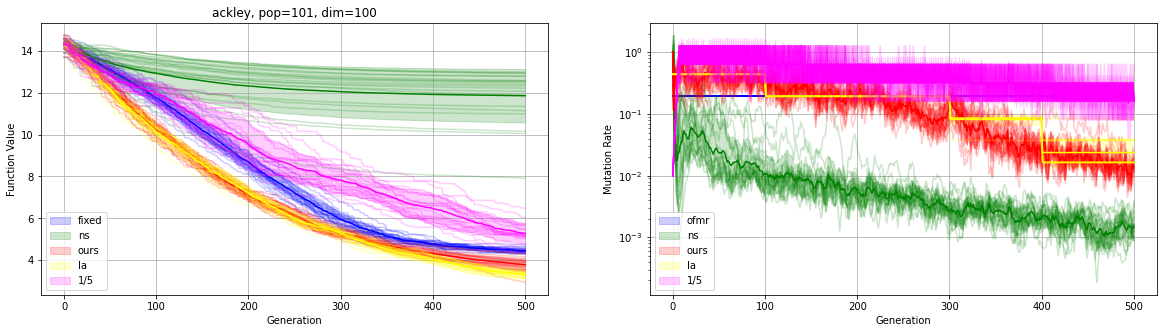

In [1699]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
plt.sca(axs[0])
plt.title(f'{optim_fn.__name__}, pop={n_pop}, dim={n_dim}')
plt.xlabel('Generation');plt.ylabel('Function Value')
plot_graph(fits.min(dim=-1).values[0], 'fixed', 'blue')
plot_graph(fits.min(dim=-1).values[1], 'ns', 'green')
plot_graph(fits.min(dim=-1).values[2], 'ours', 'red')
plot_graph(fits.min(dim=-1).values[3], 'la', 'yellow')
plot_graph(fits.min(dim=-1).values[4], '1/5', 'magenta')
plt.grid()

plt.sca(axs[1])
plt.xlabel('Generation');plt.ylabel('Mutation Rate')
plot_graph(mrs[0].repeat(n_gen, 1).T, 'ofmr', 'blue', logscale=True)
plot_graph(mrs[1][..., 0].log().mean(dim=-1).exp(), 'ns', 'green', logscale=True)
plot_graph(mrs[2][..., 0].log().mean(dim=-1).exp(), 'ours', 'red', logscale=True)
plot_graph(mrs[3], 'la', 'yellow', logscale=True)
plot_graph(mrs[4], '1/5', 'magenta', logscale=True)
plt.grid()

In [1497]:
for dim in np.logspace(0, 3, 7):
    dim = int(dim)
    ofmr = []
    for i in tqdm(range(5)):
        ofmr.append(calc_ofmr(torch.randn(101, dim), ackley, 100, ofmr_mrs, 3)[0].item())
    print(dim, ofmr)


  0%|          | 0/5 [00:00<?, ?it/s]

1 [tensor(0.0032), tensor(0.0032), tensor(0.0032), tensor(0.0032), tensor(0.0032)]


  0%|          | 0/5 [00:00<?, ?it/s]

3 [tensor(0.0072), tensor(0.0072), tensor(0.0072), tensor(0.0072), tensor(0.0072)]


  0%|          | 0/5 [00:00<?, ?it/s]

10 [tensor(0.0848), tensor(0.0164), tensor(0.0164), tensor(0.0164), tensor(0.0164)]


  0%|          | 0/5 [00:00<?, ?it/s]

31 [tensor(0.0848), tensor(0.0848), tensor(0.0848), tensor(0.0848), tensor(0.0848)]


  0%|          | 0/5 [00:00<?, ?it/s]

100 [tensor(0.0373), tensor(0.0848), tensor(0.0848), tensor(0.0848), tensor(0.0848)]


  0%|          | 0/5 [00:00<?, ?it/s]

316 [tensor(0.0373), tensor(0.0373), tensor(0.0373), tensor(0.0373), tensor(0.0373)]


100%|██████████| 5/5 [00:25<00:00,  5.09s/it]

1000 [tensor(0.0164), tensor(0.0373), tensor(0.0373), tensor(0.0373), tensor(0.0373)]


In [1596]:
def plot_graph(f, name, c, logscale=False):
    if logscale:
        y = f.log().mean(dim=0).exp()
        yerr = f.log().std(dim=0).exp()
    else:
        y = f.mean(dim=0)
        yerr = f.std(dim=0)
        
#     plt.figure(figsize=(10, 5))
    x = np.arange(len(y))
    c = colors.hex2color(colors.cnames[c])
    plt.plot(x, y, color=c, label=None)
    c = list(c)+[0.2]
    if logscale:
        plt.fill_between(x, y/yerr, y*yerr, color=c, label=name)
    else:
        plt.fill_between(x, y-yerr, y+yerr, color=c, label=name)
    for fi in f:
        plt.plot(x, fi, c=c)

    if logscale:
        plt.yscale('log')
    plt.legend()


In [721]:
def run_evolution_dir(pop, optim_fn, n_gen, n_mutpop=10, mr=None, mr_mut=2., tqdm=lambda x: x):
    if mr is None:
        mutpop = torch.logspace(-3, 3, n_mutpop, device=pop.device)[:, None]
        mutpop_mean = torch.zeros(n_mutpop, pop.shape[-1], device=pop.device)
        mutpop = mutpop.repeat(1, pop.shape[-1])
    else:
        mutpop = torch.linspace(mr, mr, n_mutpop, device=pop.device)[:, None]
        
    data = []
    mrpop2mr = np.arange(len(pop)-1)//int(len(pop)/len(mutpop))
    fit = optim_fn(pop)
    for i in tqdm(range(n_gen)):
        bpop = pop
        bfit = fit
        
        idxs_elite, idxs_rest, idxs_cat = calc_npop_idxs(fit)
#         pop = calc_npop_gaussian(pop, mutpop[mrpop2mr], idxs_elite, idxs_rest, idxs_cat)
        pop = calc_npop_gaussian_mean_std(pop, mutpop_mean[mrpop2mr], mutpop[mrpop2mr],
                                          idxs_elite, idxs_rest, idxs_cat)
        fit = optim_fn(pop)
        fit_mrs = (fit[1:]-bfit[idxs_rest]).reshape(len(mutpop), -1)
        data.append((bpop, bfit, mutpop, fit_mrs))
        fit_mrs = fit_mrs.min(dim=-1).values
        ie, ir, ic = calc_npop_idxs(fit_mrs)
        mutpop = calc_npop_gaussian(mutpop, 1e-2, ie, ir, ic)
        mutpop_mean = calc_npop_log_uniform(mutpop_mean, mr_mut, ie, ir, ic)
        
    # pops, fits, mrs, fitmrs
    return [torch.stack([d[i] for d in data]) for i in range(len(data[0]))]



(-5.0, 25.0)

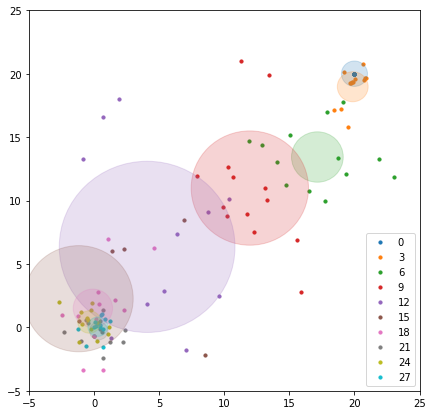

In [773]:
from matplotlib import colors
plt.figure(figsize=(7,7))
for i in range(0, len(pops), 3):
    p = pops[i]
    c = plt.gca()._get_lines.get_next_color()
    c = colors.hex2color(c)
    plt.scatter(*p.T, s=10, color=c, label=f'{i}')
    s = mrs[:, :, 0].log().mean(dim=-1).exp()[i]
    circle1 = plt.Circle(p.mean(dim=0), s, color=list(c)+[.2])
    plt.gca().add_patch(circle1)
    
plt.legend()
plt.xlim(-5, 25)
plt.ylim(-5, 25)

tensor(0.4833)


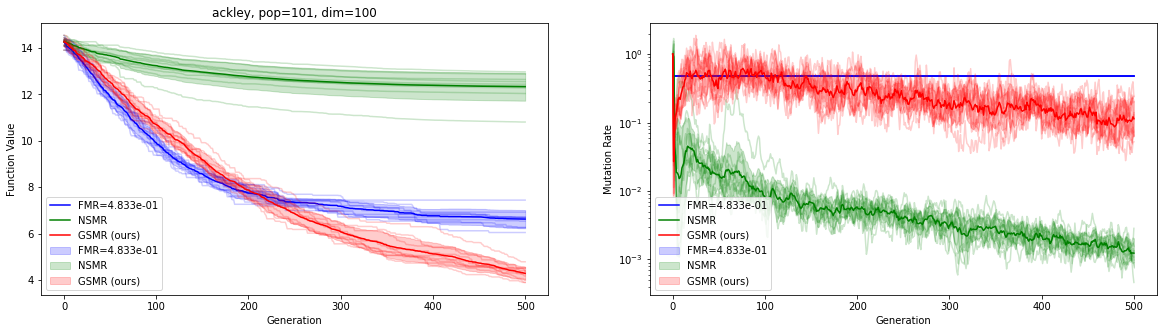

tensor(0.4833)


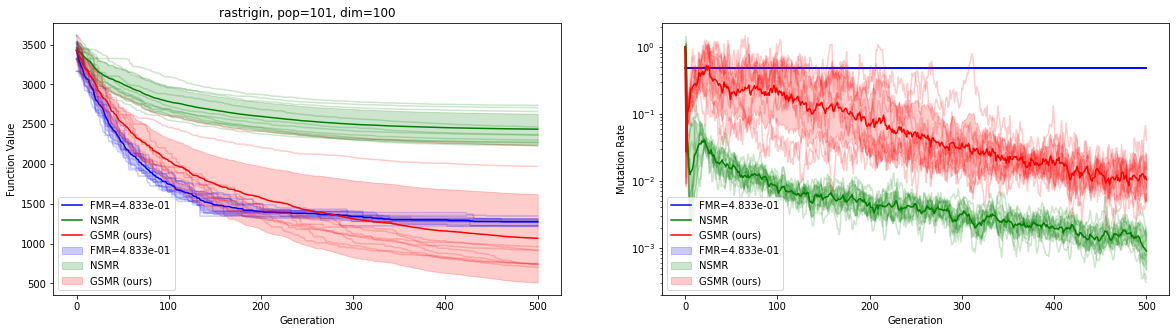

tensor(0.4833)


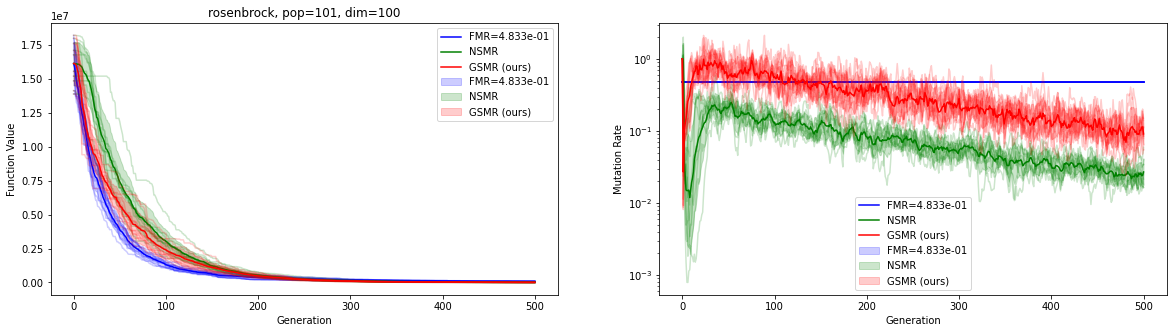

tensor(0.4833)


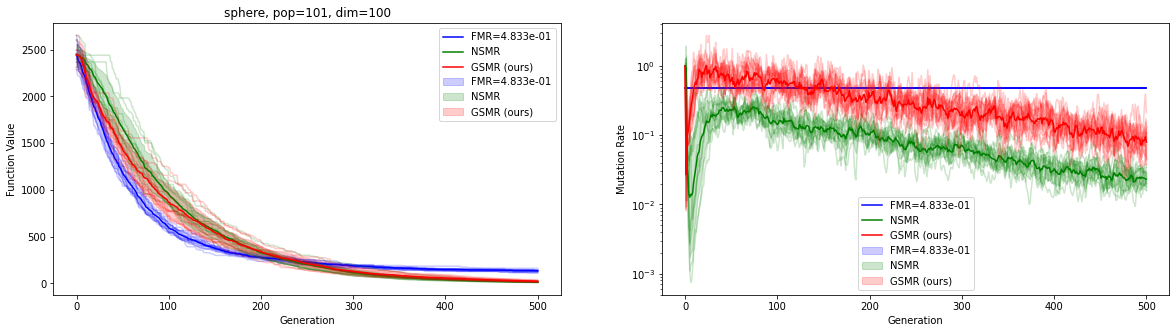

In [1140]:
for optim_fn in [ackley, rastrigin, rosenbrock, sphere]:
# for optim_fn in [ackley]:
    names = ['FMR', 'NSMR', 'GSMR (ours)']
    cs = ['blue', 'green', 'red']
    n_pop = 101
    n_dim = 100
    n_seed = 10
    n_gen = 500
    mr = 1e-2
    
    const = 6.
    
    pop = torch.randn(n_pop, n_dim)*const
    mrs = torch.logspace(-3, 0, 20)
#     mrs = [1e-2]
    ofmr, _ = get_optimal_fmr(pop, optim_fn, 100, mrs, 3)
    print(ofmr)
    names[0] = names[0]+f'={ofmr:.03e}'
    
    f = []
    mrs_ns = []
    mrs_ours = []
    for i in range(n_seed):
        do_seed(i)
        pop = torch.randn(n_pop, n_dim)*const
        pops, fits = run_evolution_base(pop, optim_fn, n_gen, mr=ofmr)
        f.append(fits)
        pops, fits, mrs = run_evolution_ns(pop, optim_fn, n_gen, mr=None)
        f.append(fits);mrs_ns.append(mrs)
        pops, fits, mrs, fits_mr = run_evolution_ours(pop, optim_fn, n_gen, 4, mr=None)
        f.append(fits);mrs_ours.append(mrs)
    f = torch.stack(f)
    fmin = f.reshape(n_seed, 3, *f.shape[1:]).min(dim=-1).values
    mrs_ns = torch.stack(mrs_ns)
    mrs_ns = mrs_ns[..., 0].log().mean(dim=-1).exp()
    mrs_ours = torch.stack(mrs_ours)
    mrs_ours = mrs_ours[..., 0].log().mean(dim=-1).exp()
    
    fig, axs = plt.subplots(1, 2, figsize=(20,5))
    plt.sca(axs[0])
    for i in range(3):
        plot_graph(fmin[:, i], names[i], cs[i])
    plt.title(f'{optim_fn.__name__}, pop={n_pop}, dim={n_dim}')
    plt.xlabel('Generation');plt.ylabel('Function Value')
    plt.sca(axs[1])
    plt.xlabel('Generation');plt.ylabel('Mutation Rate')
    plot_graph(torch.full_like(mrs_ns, ofmr), names[0], cs[0], logscale=True)
    plot_graph(mrs_ns, names[1], cs[1], logscale=True)
    plot_graph(mrs_ours, names[2], cs[2], logscale=True)
    
    plt.show()

